# ConFUse-net: A Hybrid Transformer Architecture Based on UTNet and UCTransNet

In this notebook we implement ConFUse-net, a novel architecture for medical image segmentation. ConFUse-net draws from two recent works:

* [UCTransNet: Rethinking the Skip Connections in U-Net from a Channel-wise Perspective with Transformer](https://arxiv.org/pdf/2109.04335.pdf)
* [UTNet: A Hybrid Transformer Architecture for
Medical Image Segmentation](https://arxiv.org/abs/2107.00781)

Some code in this notebook is borrwed from UTNet's [official public implementation](https://github.com/yhygao/UTNet). This code is clearly labeled.

Additionally, we train and evaluate U-net, UTNet, and ConFUse-net on the data from the [Multi-Atlas Labeling Beyond the Cranial Vault - Workshop and Challenge](https://www.synapse.org/#!Synapse:syn3193805/wiki/217789) (also known as the Synapse dataset). Instructions for how to download and import the data is included in the acompanying README file.

## Imports
If running the project in Colab, most of these should already be installed. The only library that we needed to install was einops. To install this library, you can run "pip install einops" in a terminal window or "!pip install einops" in a cell.

In [2]:
import os
import glob

import albumentations as A
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from einops import rearrange
from google.colab import drive
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

## Constants
You will likely need to modify the first six lines (ZIP_PATH - NET_PATH) to fit your specific environment.

In [3]:
# path to RawData.zip
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/ECE 695 (MLB)/Final Project/data/multi-class/RawData.zip"

# paths to training images and masks
TRAIN_IMG_PATH = "/content/RawData/Training/img"
TRAIN_MASK_PATH = "/content/RawData/Training/label"

# paths to testing images and masks
TEST_IMG_PATH = "/content/RawData/Testing/img"
TEST_MASK_PATH = "/content/RawData/Testing/label"

# path to directory storing trained models
NET_PATH = "/content/drive/MyDrive/Colab Notebooks/ECE 695 (MLB)/Final Project/models"

N_CLASSES = 14        # number of classes in the dataset

N_TRAIN = 20          # number of training scans
TRAIN_LEN = 928       # total number of 2D images in training set

TEST_LEN = 597        # total number of 2D images in testing set
N_TEST = 10           # number of testing scans

DTYPE = torch.float   # the type to convert images to during data loading
IMG_MULTIPLIER = 0.6  # the first IMG_MULTIPLIER slices in a scan will be dropped
RESIZE = 256          # the size of the resized images

N_EPOCHS = 150        # number of epochs to train for
LEARNING_RATE = 1e-4  # learning rate for training
BATCH_SIZE = 8        # batch size for training

## Dataset

The following section deals with importing, unpacking, and loading the Synapse dataset.

#### Mount Google Drive

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


#### Unpack the zipped file from Google Drive into Colab
The following cell unpacks RawData.zip from Google Drive into the Colab environment. If the archive has already been unpacked, there is no need to run it!

To avoid unneccesary runs, I've commented out the second line. If you need to unpack the file, uncomment it.

In [7]:
command = f"unzip '{ZIP_PATH}' -d '/content'"
# !{command}

#### Dataset Class

This class will be used to load, process, and disperse images from the dataset.

In [8]:
class Synapse(Dataset):
  """
  This class is used to load, process, and disperse images from the Synapse dataset.

  Args:
    torch_transform (torchvision.transforms.transforms.Compose): The non-random transformations to apply to the images and masks.
    alb_transform (albumentations.core.composition.Compose): The random transformations to apply to the images and masks.
    train (bool): Whether to load training or testing images and masks.

  Attributes:
    train (bool): Whether using training or testing images and masks.
    img_dir (str): The directory containing the images.
    mask_dir (str): The directory containing the masks.
    n_files (int): The number of files in the dataset.
    torch_transform (torchvision.transforms.transforms.Compose): The non-random transformations to apply to the images and masks.
    alb_transform (albumentations.core.composition.Compose): The random transformations to apply to the images and masks.
    img_files ([str]]): The list of image file paths.
    mask_files ([str]]): The list of mask file paths.
    curr_file_idx (int): The index in self.img_files of the current image file.
    curr_slice_idx (int): The index of the current slice in the current image file.
    curr_img (np.ndarray): The current image file.
    curr_mask (np.ndarray): The current mask file
  """
  def __init__(self, torch_transform = None, alb_transform=None, train=True):
    self.train = train
    # if training, use training images and masks
    if train:
      self.img_dir = TRAIN_IMG_PATH
      self.mask_dir = TRAIN_MASK_PATH
      self.n_files = N_TRAIN

    # if testing, use testing images and masks
    else:
      self.img_dir = TEST_IMG_PATH
      self.mask_dir = TEST_MASK_PATH
      self.n_files = N_TEST

    # save image and mask transforms for later
    self.torch_transform = torch_transform
    self.alb_transform = alb_transform

    # sort the image and mask filenames
    self.img_files = sorted(glob.glob(f"{self.img_dir}/*.nii.gz"))
    self.mask_files = sorted(glob.glob(f"{self.mask_dir}/*.nii.gz"))

    self.curr_file_idx = 0    # keeps track of what file we're on
    self.curr_slice_idx = 0   # keeps track of what slice we're on

    self.curr_img = None      # the image file currently being sliced
    self.curr_mask = None     # the mask file currently being sliced

    # load first image, mask pair
    self.update()


  def __getitem__(self, index):
    """
    Loads, processes, and returns a single image and mask pair.

    Parameters:
      index (int): The index of the image and mask pair to load.

    Returns:
      (torch.Tensor, torch.Tensor): The image and mask tensors.
    """
    # check to see if we've reached the last slice of the image
    if self.curr_slice_idx >= self.curr_img.shape[2]:

      # check to see if we've reached the last scan in the dataset
      if self.curr_file_idx >= self.n_files-1:

        # if we've reached the last scan, go back to the first scan
        self.curr_file_idx = 0

      # if we haven't reached the last scan, go onto the next scan
      else:
        self.curr_file_idx += 1

      # if we've reached the last slice, go back to the first slice
      self.curr_slice_idx = 0

      # now, load the new image and mask
      self.update()

    # use the current slice index to return the appropriate slices
    img_slice = self.curr_img[:,:,self.curr_slice_idx]
    mask_slice = self.curr_mask[:,:,self.curr_slice_idx]

    # then update the slice
    self.curr_slice_idx += 1

    # apply image and mask transforms (if applicable)
    if self.alb_transform:
      augmentation = self.alb_transform(image=img_slice, mask=mask_slice)
      img_slice = augmentation["image"]
      mask_slice = augmentation["mask"]

    if self.torch_transform:
      img_slice = self.torch_transform(img_slice)
      mask_slice = self.torch_transform(mask_slice)

    # min-max scale the image (0-1)
    min_intensity = torch.min(img_slice)
    max_intensity = torch.max(img_slice)
    img_slice = (img_slice - min_intensity) / (max_intensity - min_intensity)

    # return the transformed slices
    return (img_slice, mask_slice)


  def __len__(self):
    """
    Returns the number of image and mask pairs in the dataset.

    Parameters:
      None

    Returns:
      (int): The number of image and mask pairs in the dataset.
    """
    return TRAIN_LEN if self.train else TEST_LEN


  def load_file(self, file_path):
    """
    Loads image or mask data into a numpy array.

    Parameters:
      file_path (str): The path to the image or mask file.

    Returns:
      (numpy.ndarray): The loaded image or mask data.
    """
    # load the image or mask data
    full = nib.load(file_path).get_fdata()

    # drop the first IMG_MULTIPLIER percent of slices (since these are likely empty)
    slices = full.shape[2]
    start = int(slices * IMG_MULTIPLIER)

    return full[:,:,start:]


  def update_img(self):
    """
    Fetches, loads, and updates the current image file.

    Parameters:
      None

    Returns:
      None
    """
    img_path = self.img_files[self.curr_file_idx]
    self.curr_img = self.load_file(img_path)


  def update_mask(self):
    """
    Fetches, loads, and updates the current mask file.

    Parameters:
      None

    Returns:
      None
    """
    mask_path = self.mask_files[self.curr_file_idx]
    self.curr_mask = self.load_file(mask_path)


  def update(self):
    """
    Updates the current image and mask files.

    Parameters:
      None

    Returns:
      None
    """
    self.update_img()
    self.update_mask()

## Architectures

#### Attention
All of the code in the following cell (i.e., LinearAttention, RelativePositionEmbedding, and RelativePositionBias classes) comes from the [official UTNet codebase](https://github.com/yhygao/UTNet/blob/6bdcc97e2364d127e1d2d20e307f935c8fffbff0/model/conv_trans_utils.py#L80).

In [9]:
class LinearAttention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=64, attn_drop=0., proj_drop=0., reduce_size=16, projection='interp', rel_pos=True):
    super().__init__()

    self.inner_dim = dim_head * heads
    self.heads = heads
    self.scale = dim_head ** (-0.5)
    self.dim_head = dim_head
    self.reduce_size = reduce_size
    self.projection = projection
    self.rel_pos = rel_pos

    self.to_qkv = nn.Conv2d(dim, self.inner_dim*3, kernel_size=1, stride=1, padding=0, bias=True)
    self.to_out = nn.Conv2d(self.inner_dim, dim, kernel_size=1, stride=1, padding=0, bias=True)

    self.attn_drop = nn.Dropout(attn_drop)
    self.proj_drop = nn.Dropout(proj_drop)

    if self.rel_pos:
      self.relative_position_encoding = RelativePositionBias(heads, reduce_size, reduce_size)

  def forward(self, x):
    B, C, H, W = x.shape

    qkv = self.to_qkv(x)
    q, k, v = qkv.chunk(3, dim=1)

    if self.projection == 'interp' and H != self.reduce_size:
      k, v = map(lambda t: F.interpolate(t, size=self.reduce_size, mode='bilinear', align_corners=True), (k, v))

    elif self.projection == 'maxpool' and H != self.reduce_size:
      k, v = map(lambda t: F.adaptive_max_pool2d(t, output_size=self.reduce_size), (k, v))

    q = rearrange(q, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head, heads=self.heads, h=H, w=W)
    k, v = map(lambda t: rearrange(t, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head, heads=self.heads, h=self.reduce_size, w=self.reduce_size), (k, v))

    q_k_attn = torch.einsum('bhid,bhjd->bhij', q, k)

    if self.rel_pos:
      relative_position_bias = self.relative_position_encoding(H, W)
      q_k_attn += relative_position_bias

    q_k_attn *= self.scale
    q_k_attn = F.softmax(q_k_attn, dim=-1)
    q_k_attn = self.attn_drop(q_k_attn)

    out = torch.einsum('bhij,bhjd->bhid', q_k_attn, v)
    out = rearrange(out, 'b heads (h w) dim_head -> b (dim_head heads) h w', h=H, w=W, dim_head=self.dim_head, heads=self.heads)

    out = self.to_out(out)
    out = self.proj_drop(out)

    return out

class RelativePositionEmbedding(nn.Module):
  def __init__(self, dim, shape):
    super().__init__()

    self.dim = dim
    self.shape = shape

    self.key_rel_w = nn.Parameter(torch.randn((2*self.shape-1, dim))*0.02)
    self.key_rel_h = nn.Parameter(torch.randn((2*self.shape-1, dim))*0.02)

    coords = torch.arange(self.shape)
    relative_coords = coords[None, :] - coords[:, None]
    relative_coords += self.shape - 1

    self.register_buffer('relative_position_index', relative_coords)



  def forward(self, q, Nh, H, W, dim_head):
    B, _, _, dim = q.shape
    q = rearrange(q, 'b heads (h w) dim_head -> b heads h w dim_head', b=B, dim_head=dim_head, heads=Nh, h=H, w=W)

    rel_logits_w = self.relative_logits_1d(q, self.key_rel_w, 'w')
    rel_logits_h = self.relative_logits_1d(q.permute(0, 1, 3, 2, 4), self.key_rel_h, 'h')

    return rel_logits_w, rel_logits_h

  def relative_logits_1d(self, q, rel_k, case):

    B, Nh, H, W, dim = q.shape

    rel_logits = torch.einsum('bhxyd,md->bhxym', q, rel_k)

    if W != self.shape:
      relative_index= torch.repeat_interleave(self.relative_position_index, W//self.shape, dim=0)

    relative_index = relative_index.view(1, 1, 1, W, self.shape)
    relative_index = relative_index.repeat(B, Nh, H, 1, 1)

    rel_logits = torch.gather(rel_logits, 4, relative_index)
    rel_logits = rel_logits.unsqueeze(3)
    rel_logits = rel_logits.repeat(1, 1, 1, self.shape, 1, 1)

    if case == 'w':
      rel_logits = rearrange(rel_logits, 'b heads H h W w -> b heads (H W) (h w)')

    elif case == 'h':
      rel_logits = rearrange(rel_logits, 'b heads W w H h -> b heads (H W) (h w)')

    return rel_logits




class RelativePositionBias(nn.Module):
  # input-independent relative position attention
  # As the number of parameters is smaller, so use 2D here
  # Borrowed some code from SwinTransformer: https://github.com/microsoft/Swin-Transformer/blob/main/models/swin_transformer.py
  def __init__(self, num_heads, h, w):
    super().__init__()
    self.num_heads = num_heads
    self.h = h
    self.w = w

    self.relative_position_bias_table = nn.Parameter(torch.randn((2*h-1) * (2*w-1), num_heads)*0.02)

    coords_h = torch.arange(self.h)
    coords_w = torch.arange(self.w)
    coords = torch.stack(torch.meshgrid([coords_h, coords_w])) # 2, h, w
    coords_flatten = torch.flatten(coords, 1) # 2, hw

    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()
    relative_coords[:, :, 0] += self.h - 1
    relative_coords[:, :, 1] += self.w - 1
    relative_coords[:, :, 0] *= 2 * self.h - 1
    relative_position_index = relative_coords.sum(-1) # hw, hw

    self.register_buffer("relative_position_index", relative_position_index)

  def forward(self, H, W):

    relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(self.h, self.w, self.h*self.w, -1) #h, w, hw, nH
    relative_position_bias_expand_h = torch.repeat_interleave(relative_position_bias, H//self.h, dim=0)
    relative_position_bias_expanded = torch.repeat_interleave(relative_position_bias_expand_h, W//self.w, dim=1) #HW, hw, nH

    relative_position_bias_expanded = relative_position_bias_expanded.view(H*W, self.h*self.w, self.num_heads).permute(2, 0, 1).contiguous().unsqueeze(0)

    return relative_position_bias_expanded


#### Residual Basic Block

In [10]:
class ResidualBasicBlock(nn.Module):
  """
  This class represents a residual basic block in the U-net, UTNet, and ConFUse-net architectures.

  Args:
    in_channels (int): The number of channels in the input tensor.
    mid_channels (int): The number of channels after the first convolution.
    out_channels (int): The number of channels in the output tensor.
    utnet (bool): Set to True to include a shortcut connection in the residual block (i.e., to add the input tensor to the output tensor).

  Attributes:
    utnet (bool): If True, include a shortcut connection in the residual block (i.e., to add the input tensor to the output tensor).
    double_conv (nn.Sequential): A sequential container for the double convolution layers.
    shortcut (nn.Sequential): A sequential container for the shortcut connection.
  """
  def __init__(self, in_channels, mid_channels, out_channels, utnet=True):
    super(ResidualBasicBlock, self).__init__()
    self.utnet = utnet

    # standard double conv->bn->relu used in U-net
    self.double_conv = nn.Sequential(
      # preserve spatial dimensions by using kernel size of 3 and padding of 1
      nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(mid_channels, dtype=DTYPE),
      nn.ReLU(inplace=True),

      # preserve spatial dimensions by using kernel size of 3 and padding of 1
      nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels, dtype=DTYPE),
      nn.ReLU(inplace=True)
    )

    # UTNet includes an extra step block which down-samples the input so that it can be added to the output
    if utnet:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm2d(out_channels, dtype=DTYPE),
        nn.ReLU(inplace=True)
      )


  def forward(self, x):
    """
    Forward pass of the residual basic block.

    Parameters:
      x (torch.Tensor): The input tensor.

    Returns:
      (torch.Tensor): The output tensor.
    """

    # send the input through the double conv->bn->relu
    out = self.double_conv(x)

    # if appropriate, use shortcut to downsample x and add to input
    if self.utnet:
      x = self.shortcut(x)
      return out + x

    # otherwise, just return output of double_conv
    else:
      return out

#### Transformer Block

In [11]:
class TransformerBasicBlock(nn.Module):
  """
  This class represents a Transformer Block used in UTNet and ConFUse-net architectures.

  Args:
    channels (int): The number of channels in the input and output tensors.

  Attributes:
    mhsa (nn.Sequential): A sequential container for the multi-head self-attention layer.
    residual (nn.Sequential): A sequential container for the residual block.
  """
  def __init__(self, channels):
    super(TransformerBasicBlock, self).__init__()

    self.mhsa = nn.Sequential(
        nn.BatchNorm2d(channels),
        LinearAttention(channels)
    )

    self.residual = nn.Sequential(
        nn.BatchNorm2d(channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels, channels, kernel_size=1, bias=False)
    )


  def forward(self, x):
    """
    Forward pass of the transformer block.

    Parameters:
      x (torch.Tensor): The input tensor.

    Returns:
      (torch.Tensor): The output tensor.
    """

    # apply mhsa to input, then add the input and mhsa output together
    mid = x + self.mhsa(x)

    # apply the residual block to the intermediate tensor then add the two together
    out = mid + self.residual(mid)
    return out

#### ConFuse Module

In [12]:
class SkipConv(nn.Module):
  """
  This class represents the ConFuse module in the ConFUse-net architecture.

  Args:
    hw ([int]): The heights and widths of the input and output tensors.
    channels ([int]): The number of channels in the input and output tensors.

  Attributes:
    hw ([int]): The heights and widths of the input and output tensors.
    channels ([int]): The number of channels in the input and output tensors.
    rbb (nn.Sequential): A sequential container for the residual basic block.
  """
  def __init__(self, hw, channels):
    super(SkipConv, self).__init__()

    self.hw = hw
    self.channels = channels

    # add up all the channels in the four input tensors
    n_chan = sum(channels)

    # we will append all input tensors in the channel dimension and pass the result to rbb
    self.rbb = ResidualBasicBlock(n_chan, n_chan, n_chan, utnet=False)


  def forward(self, x1, x2, x3, x4):
    """
    Forward pass of the ConFuse module.

    Parameters:
      x1 (torch.Tensor): The first input tensor (highest spatial, lowest channel dimensions).
      x2 (torch.Tensor): The second input tensor.
      x3 (torch.Tensor): The third input tensor.
      x4 (torch.Tensor): The fourth input tensor (highest channel, lowest spatial dimensions).

    Returns:
      (torch.Tensor): The output tensor.
    """

    # use bi-linear interpolation to bring each tensor to the same spatial dimensions
    x1 = F.interpolate(x1, size=self.hw[2], mode='bilinear', align_corners=False)
    x2 = F.interpolate(x2, size=self.hw[2], mode='bilinear', align_corners=False)
    x4 = F.interpolate(x4, size=self.hw[2], mode='bilinear', align_corners=False)

    # concatenate the interpolated tensors in the channel dimension and send through rbb
    x = torch.cat((x1, x2, x3, x4), dim=1)
    out = self.rbb(x)

    # divide up the output into new x1, x2, x3, and x4, ensuring channels are consistent
    x1 = out[:,:self.channels[0],:,:]

    start, end = self.channels[0], self.channels[0]+self.channels[1]
    x2 = out[:,start:end,:,:]

    start, end = self.channels[0]+self.channels[1], self.channels[0]+self.channels[1]+self.channels[2]
    x3 = out[:,start:end,:,:]

    start = self.channels[0]+self.channels[1]+self.channels[2]
    x4 = out[:,start:,:,:]

    # use bi-linear interpolation to scale the new x's down to the input sizes
    x1 = F.interpolate(x1, size=self.hw[0], mode='bilinear', align_corners=False)
    x2 = F.interpolate(x2, size=self.hw[1], mode='bilinear', align_corners=False)
    x4 = F.interpolate(x4, size=self.hw[3], mode='bilinear', align_corners=False)

    return x1, x2, x3, x4

#### U-net

In [13]:
class UNet(nn.Module):
  """
  This class represents the U-net architecture.

  Args:
    None

  Attributes:
    encoder1 (nn.Sequential): A sequential container for the first encoder block.
    encoder2 (nn.Sequential): A sequential container for the second encoder block.
    encoder3 (nn.Sequential): A sequential container for the third encoder block.
    encoder4 (nn.Sequential): A sequential container for the fourth encoder block.
    bottleneck (nn.Sequential): A sequential container for the bottleneck block.
    decoder4 (nn.Sequential): A sequential container for the fourth decoder block.
    decoder3 (nn.Sequential): A sequential container for the third decoder block.
    decoder2 (nn.Sequential): A sequential container for the second decoder block.
    decoder1 (nn.Sequential): A sequential container for the first decoder block.
  """
  def __init__(self):
    super(UNet, self).__init__()

    # * ================ ENCODER ================ *
    # first (shallowest) encoder layer (highest spatial, lowest channel dimensions)
    self.encoder1 = nn.Sequential(
        ResidualBasicBlock(1, 32, 32, utnet=False),
        ResidualBasicBlock(32, 64, 64, utnet=False)
    )

    # second encoder layer
    self.encoder2 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(64, 128, 128, utnet=False)
    )

    # third encoder layer
    self.encoder3 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(128, 256, 256, utnet=False)
    )

    # fourth (deepest) encoder layer (highest channel, lowest spatial dimensions)
    self.encoder4 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(256, 512, 512, utnet=False)
    )

    # * ================ BOTTLENECK ================ *
    self.bottleneck = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(512, 1024, 1024, utnet=False),
        nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    )

    # * ================ DECODER ================ *
    # fourth (deepest) decoder layer (highest channel, lowest spatial dimensions)
    self.decoder4 = nn.Sequential(
        ResidualBasicBlock(1024, 512, 512, utnet=False),
        nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    )

    # third decoder layer
    self.decoder3 = nn.Sequential(
        ResidualBasicBlock(512, 256, 256, utnet=False),
        nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    )

    # second decoder layer
    self.decoder2 = nn.Sequential(
        ResidualBasicBlock(256, 128, 128, utnet=False),
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    )

    # first (shallowest) decoder layer (highest spatial, lowest channel dimensions)
    self.decoder1 = nn.Sequential(
        ResidualBasicBlock(128, 64, 64, utnet=False),
        ResidualBasicBlock(64, 32, 32, utnet=False),
        nn.Conv2d(32, N_CLASSES, kernel_size=1)
    )


  def forward(self, x):
    """
    Forward pass of U-net.

    Parameters:
      x (torch.Tensor): The input tensor.

    Returns:
      (torch.Tensor): The output tensor.
    """

    # begin encoder
    en1out = self.encoder1(x)
    en2out = self.encoder2(en1out)
    en3out = self.encoder3(en2out)
    en4out = self.encoder4(en3out)

    # bottleneck layer
    bottleOut = self.bottleneck(en4out)

    # begin decoder
    skip4 = torch.cat((en4out, bottleOut), dim=1)
    de4out = self.decoder4(skip4)

    skip3 = torch.cat((en3out, de4out), dim=1)
    de3out = self.decoder3(skip3)

    skip2 = torch.cat((en2out, de3out), dim=1)
    de2out = self.decoder2(skip2)

    skip1 = torch.cat((en1out, de2out), dim=1)
    de1out = self.decoder1(skip1)

    return de1out

#### UTNet

In [14]:
class UTNet(nn.Module):
  """
  This class represents the UTNet architecture.

  Args:
    None

  Attributes:
    encoder1 (nn.Sequential): A sequential container for the first encoder block.
    encoder2 (nn.Sequential): A sequential container for the second encoder block.
    encoder3 (nn.Sequential): A sequential container for the third encoder block.
    encoder4 (nn.Sequential): A sequential container for the fourth encoder block.
    bottleneck (nn.Sequential): A sequential container for the bottleneck block.
    decoder4 (nn.Sequential): A sequential container for the fourth decoder block.
    decoder3 (nn.Sequential): A sequential container for the third decoder block.
    decoder2 (nn.Sequential): A sequential container for the second decoder block.
    decoder1 (nn.Sequential): A sequential container for the first decoder block.
  """
  def __init__(self):
    super(UTNet, self).__init__()

    # * ================ ENCODER ================ *
    # first (shallowest) encoder layer (highest spatial, lowest channel dimensions)
    self.encoder1 = nn.Sequential(
        ResidualBasicBlock(1, 32, 32),
        ResidualBasicBlock(32, 64, 64)
    )

    # second encoder layer
    self.encoder2 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(64, 128, 128),
        TransformerBasicBlock(128)
    )

    # third encoder layer
    self.encoder3 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(128, 256, 256),
        TransformerBasicBlock(256)
    )

    # fourth (deepest) encoder layer (highest channel, lowest spatial dimensions)
    self.encoder4 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(256, 512, 512),
        TransformerBasicBlock(512)
    )

    # * ================ BOTTLENECK ================ *
    self.bottleneck = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(512, 1024, 1024),
        TransformerBasicBlock(1024),
        nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    )

    # * ================ DECODER ================ *
    # fourth (deepest) decoder layer (highest channel, lowest spatial dimensions)
    self.decoder4 = nn.Sequential(
        TransformerBasicBlock(1024),
        ResidualBasicBlock(1024, 512, 512),
        nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    )

    # third decoder layer
    self.decoder3 = nn.Sequential(
        TransformerBasicBlock(512),
        ResidualBasicBlock(512, 256, 256),
        nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    )

    # second decoder layer
    self.decoder2 = nn.Sequential(
        TransformerBasicBlock(256),
        ResidualBasicBlock(256, 128, 128),
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    )

    # first (shallowest) decoder layer (highest spatial, lowest channel dimensions)
    self.decoder1 = nn.Sequential(
        ResidualBasicBlock(128, 64, 64),
        ResidualBasicBlock(64, 32, 32),
        nn.Conv2d(32, N_CLASSES, kernel_size=1)
    )


  def forward(self, x):
    """
    Forward pass of UTNet.

    Parameters:
      x (torch.Tensor): The input tensor.

    Returns:
      (torch.Tensor): The output tensor.
    """

    # begin encoder
    en1out = self.encoder1(x)
    en2out = self.encoder2(en1out)
    en3out = self.encoder3(en2out)
    en4out = self.encoder4(en3out)

    # bottleneck layer
    bottleOut = self.bottleneck(en4out)

    # begin decoder
    skip4 = torch.cat((en4out, bottleOut), dim=1)
    de4out = self.decoder4(skip4)

    skip3 = torch.cat((en3out, de4out), dim=1)
    de3out = self.decoder3(skip3)

    skip2 = torch.cat((en2out, de3out), dim=1)
    de2out = self.decoder2(skip2)

    skip1 = torch.cat((en1out, de2out), dim=1)
    de1out = self.decoder1(skip1)

    return de1out

#### ConFUse-net

In [15]:
class USCnet(nn.Module):
  """
  This class represents the ConFUse-net architecture.

  Args:
    None

  Attributes:
    encoder1 (nn.Sequential): A sequential container for the first encoder block.
    encoder2 (nn.Sequential): A sequential container for the second encoder block.
    encoder3 (nn.Sequential): A sequential container for the third encoder block.
    encoder4 (nn.Sequential): A sequential container for the fourth encoder block.
    bottleneck (nn.Sequential): A sequential container for the bottleneck block.
    decoder4 (nn.Sequential): A sequential container for the fourth decoder block.
    decoder3 (nn.Sequential): A sequential container for the third decoder block.
    decoder2 (nn.Sequential): A sequential container for the second decoder block.
    decoder1 (nn.Sequential): A sequential container for the first decoder block.
    skipconv (SkipConv): A SkipConv object for the ConFuse module.
  """
  def __init__(self):
    super(USCnet, self).__init__()

    # * ================ ENCODER ================ *
    # first (shallowest) encoder layer (highest spatial, lowest channel dimensions)
    self.encoder1 = nn.Sequential(
        ResidualBasicBlock(1, 32, 32),
        ResidualBasicBlock(32, 64, 64)
    )

    # second encoder layer
    self.encoder2 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(64, 128, 128),
        TransformerBasicBlock(128)
    )

    # third encoder layer
    self.encoder3 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(128, 256, 256),
        TransformerBasicBlock(256)
    )

    # fourth (deepest) encoder layer (highest channel, lowest spatial dimensions)
    self.encoder4 = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(256, 512, 512),
        TransformerBasicBlock(512)
    )

    # * ================ BOTTLENECK ================ *
    self.bottleneck = nn.Sequential(
        nn.MaxPool2d(2),
        ResidualBasicBlock(512, 1024, 1024),
        TransformerBasicBlock(1024),
        nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    )

    # * ================ DECODER ================ *
    # fourth (deepest) decoder layer (highest channel, lowest spatial dimensions)
    self.decoder4 = nn.Sequential(
        TransformerBasicBlock(1024),
        ResidualBasicBlock(1024, 512, 512),
        nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    )

    # third decoder layer
    self.decoder3 = nn.Sequential(
        TransformerBasicBlock(512),
        ResidualBasicBlock(512, 256, 256),
        nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    )

    # second decoder layer
    self.decoder2 = nn.Sequential(
        TransformerBasicBlock(256),
        ResidualBasicBlock(256, 128, 128),
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    )

    # first (shallowest) decoder layer (highest spatial, lowest channel dimensions)
    self.decoder1 = nn.Sequential(
        ResidualBasicBlock(128, 64, 64),
        ResidualBasicBlock(64, 32, 32),
        nn.Conv2d(32, N_CLASSES, kernel_size=1)
    )

    # * ================ CONFUSE ================ *
    # the height/width and channels of the encoder feature maps (x1->x4)
    hw = [256, 128, 64, 32]
    chan = [64, 128, 256, 512]
    self.skipconv = SkipConv(hw, chan)


  def forward(self, x):
    """
    Forward pass of ConFUse-net.

    Parameters:
      x (torch.Tensor): The input tensor.

    Returns:
      (torch.Tensor): The output tensor.
    """

    # begin encoder
    en1out = self.encoder1(x)
    en2out = self.encoder2(en1out)
    en3out = self.encoder3(en2out)
    en4out = self.encoder4(en3out)

    # bottleneck
    bottleOut = self.bottleneck(en4out)

    # confuse module, put in 4 encoder feature maps and get out 4 globally-aware feature maps
    en1out, en2out, en3out, en4out = self.skipconv(en1out, en2out, en3out, en4out)

    # begin decoder
    skip4 = torch.cat((en4out, bottleOut), dim=1)
    de4out = self.decoder4(skip4)

    skip3 = torch.cat((en3out, de4out), dim=1)
    de3out = self.decoder3(skip3)

    skip2 = torch.cat((en2out, de3out), dim=1)
    de2out = self.decoder2(skip2)

    skip1 = torch.cat((en1out, de2out), dim=1)
    de1out = self.decoder1(skip1)

    return de1out

## Custom Dice Loss
We use Cross Entropy Loss to train our network and Dice Loss to evaluate it. PyTorch has a built-in implementation of Cross Entropy Loss, but no such implementation exists for Dice Loss. Here, we create a custom Dice Loss class.

In [16]:
class Dice(torch.nn.Module):
  """
  This class implements the Dice loss function.

  Args:
    None

  Attributes:
    None
  """
  def init(self):
    super(Dice, self).init()


  def forward(self, pred, mask, smooth = 1.0):
    """
    Forward pass of the Dice loss function.

    Parameters:
      pred (torch.Tensor): The predicted tensor.
      mask (torch.Tensor): The ground truth tensor.
      smooth (float): The smoothing factor.

    Returns:
      (torch.Tensor): The loss tensor.
    """

    # network preds have 14 channel dimensions (1 for each class), so we need to project to 1 dimension
    pred = pred.argmax(dim=1)

    # flatten pred and mask
    pred_flat = pred.contiguous().view(-1)
    mask_flat = mask.contiguous().view(-1)

    intersection = (pred_flat * mask_flat).sum()

    A_sum = torch.sum(pred_flat * pred_flat)
    B_sum = torch.sum(mask_flat * mask_flat)

    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

## Helper Functions

#### Training Function

In [17]:
def train(network, optimizer, CE, dataloader, device):
  """
  This function trains the network.

  Parameters:
    network (torch.nn.Module): The network to train.
    optimizer (torch.optim.Optimizer): The optimizer to use.
    CE (torch.nn.CrossEntropyLoss): The cross entropy loss function.
    dataloader (torch.utils.data.DataLoader): The dataloader to use.
    device (torch.device): The device to use.

  Returns:
    None
  """

  # set network to training mode
  network.train()

  for idx, (img_slice, mask_slice) in enumerate(dataloader):
    # send image and mask to device (get rid of extra dimension in mask)
    img_slice = img_slice.to(device)
    mask_slice = mask_slice.squeeze(dim=1).to(device)

    # send image to network, get classification and segmentation
    out = network(img_slice)

    # compute the cross entropy loss
    loss = CE(out, mask_slice.long())

    # zero gradient, backward pass, optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # sanity check
    if idx % 20 == 0:
      print(f'batch {idx} loss: {loss}')


#### Testing Function

In [18]:
def test(network, loss_func, dataloader, device):
  """
  This function tests the network.

  Parameters:
    network (torch.nn.Module): The network to test.
    loss_func (Dice): The Dice loss function.
    dataloader (torch.utils.data.DataLoader): The dataloader to use.
    device (torch.device): The device to use.

  Returns:
    (float): The average (dice) loss of the network.
  """

  # keep running sum of individual losses
  total_loss = 0
  network.eval()

  for idx, (img_slice, mask_slice) in enumerate(dataloader):
    # send image and mask to device
    img_slice = img_slice.to(device)
    mask_slice = mask_slice.squeeze(dim=1).to(device)

    # send image to network, get classification and segmentation
    out = net(img_slice)

    # compute the loss
    loss = loss_func(out, mask_slice.long())

    # add loss to running sum
    total_loss += loss.item()

  # return average loss
  return total_loss / len(dataloader)

#### Visualizing Functions

In [19]:
def plot_img_mask_out(img, mask, out):
  """
  This function plots the image, mask, and output of the network.

  Parameters:
    img (torch.Tensor): The image to plot.
    mask (torch.Tensor): The mask to plot.
    out (torch.Tensor): The output of the network.

  Returns:
    None
  """

  fig = plt.figure(figsize=(12, 6))

  # display the ground-truth image
  plt.subplot(1, 3, 1)
  plt.imshow(img.detach().cpu(), cmap="gray")
  plt.axis("off")

  # display the ground-truth mask
  plt.subplot(1, 3, 2)
  plt.imshow(mask.cpu())
  plt.axis("off")

  # display the output of the network
  plt.subplot(1, 3, 3)
  plt.imshow(out.cpu())
  plt.axis("off")

  plt.show()


def visualize(network, dataloader, device, n):
  """
  This function displays n images, masks, and outputs of the network.

  Parameters:
    network (torch.nn.Module): The network being used to generate the masks.
    dataloader (torch.utils.data.DataLoader): The dataloader to use.
    device (torch.device): The device to use.
    n (int): The number of images to display

  Returns:
    None
  """

  for idx, (img_slice, mask_slice) in enumerate(dataloader):
    # send image and mask to device
    img_slice = img_slice.to(device)
    mask_slice = mask_slice.squeeze(dim=1).to(device)

    # send image to network, get classification and segmentation
    out = net(img_slice)
    out = out.argmax(dim=1)

    # plot the image, mask, and output of the network
    plot_img_mask_out(img_slice[0,0,:,:], mask_slice[0,:,:], out[0,:,:])

    # break if we have displayed n images
    if idx == n:
      break

#### Model Saving Function

In [20]:
def save(network, name, epoch):
  """
  This function saves the network to a file.

  Parameters:
    network (torch.nn.Module): The network to save.
    name (str): The name of the network.
    epoch (int): The epoch number.

  Returns:
    None
  """
  print(f'=> SAVING AT EPOCH {epoch}')
  path = f'{NET_PATH}/{name}_{epoch}.pth'
  torch.save(network.state_dict(), path)

#### Parameter Counting Function

In [21]:
def count_parameters(model):
  """
  This function counts the number of parameters in the model.

  Parameters:
    model (torch.nn.Module): The model to count the parameters.

  Returns:
    int: The number of parameters in the model.
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Train a Model

In [24]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# torch transforms involve non-random transformations (e.g., ToTensor)
torch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(DTYPE)
])

# we use albumentations library to apply random transforms the same to image and mask
alb_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE),
])

# create training dataset and loader
dataset = Synapse(torch_transform, alb_transform, train=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# define model, optimizer, and loss function
net = USCnet().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
CE = nn.CrossEntropyLoss()

# begin training
for epoch in range(N_EPOCHS):
  print(f"* =========================== EPOCH {epoch} =========================== *")
  train(net, optimizer, CE, dataloader, device)

  # save the model every 30 epochs (change the name here depending on which network is being trained)
  if epoch == 30:
    save(net, "uscnet", epoch)
    break

## Test the Model

In [27]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# torch transforms involve non-random transformations (e.g., ToTensor)
torch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(DTYPE)
])

# we use albumentations library to apply random transforms the same to image and mask
alb_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE),
])

# create training dataset and loader
dataset = Synapse(torch_transform, alb_transform, train=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# load model from file (change filename here to load different model)
net = USCnet().to(device)
net.load_state_dict(torch.load(f"{NET_PATH}/uscnet_30.pth"))

# we use Dice loss to evaluate the model
loss = Dice()

# test the model
avg_dice = test(net, loss, dataloader, device)
print(f"Average Dice Loss: {avg_dice:.4f}")

cuda
Average Dice Loss: 0.3477


## Visualize Outputs

cuda


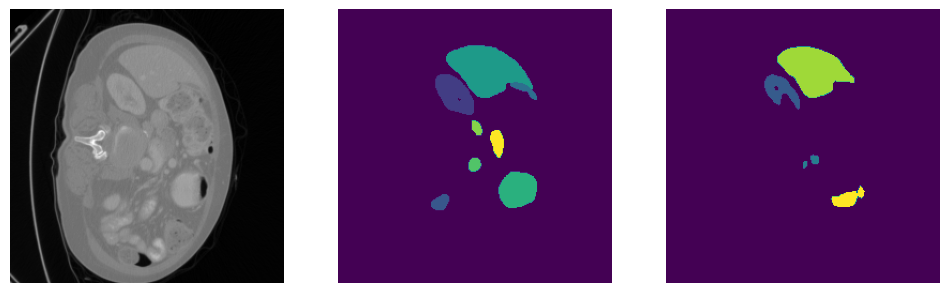

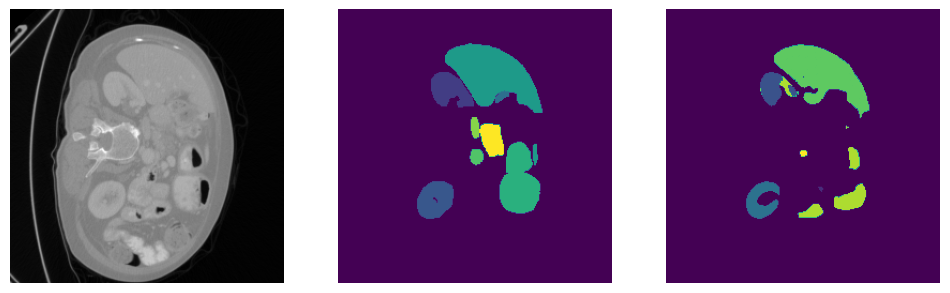

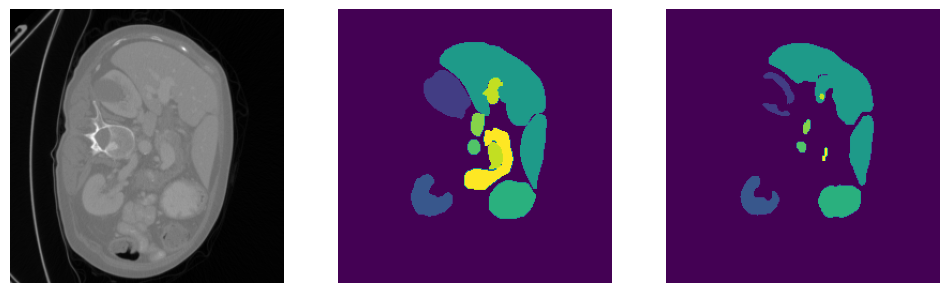

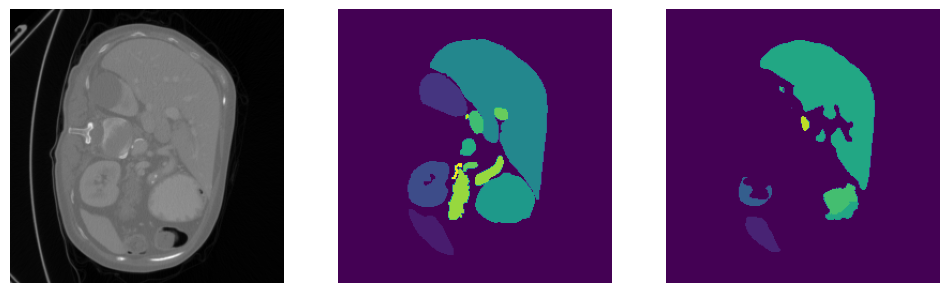

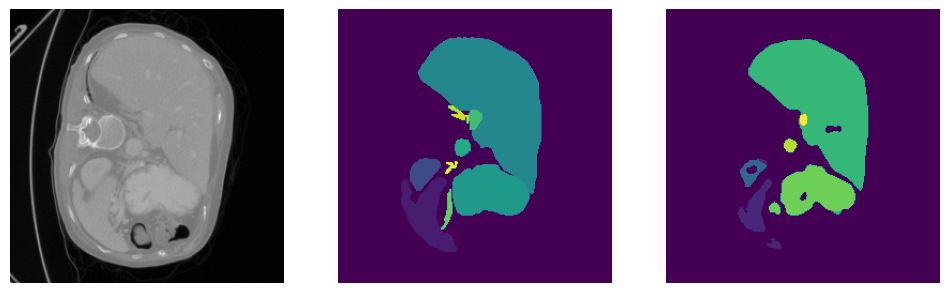

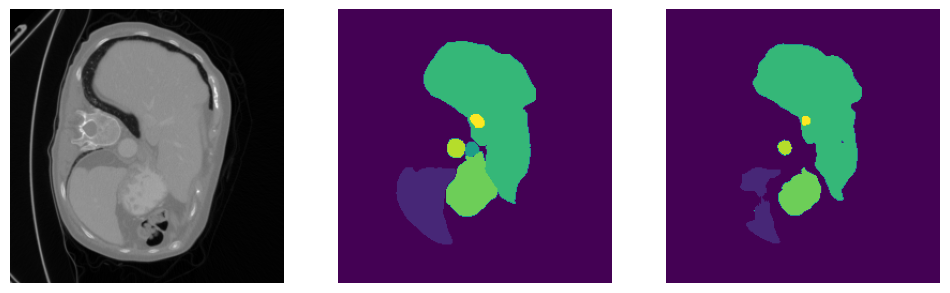

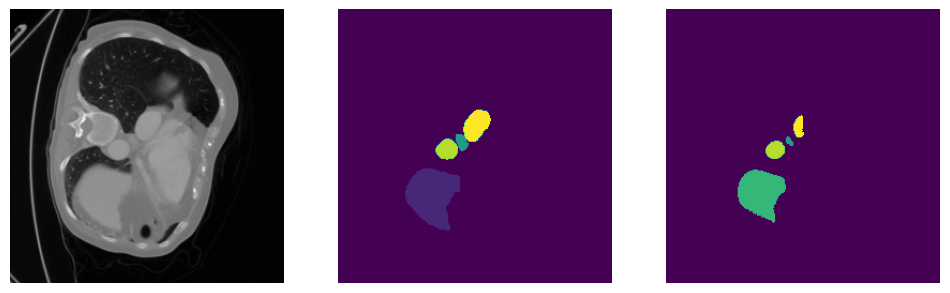

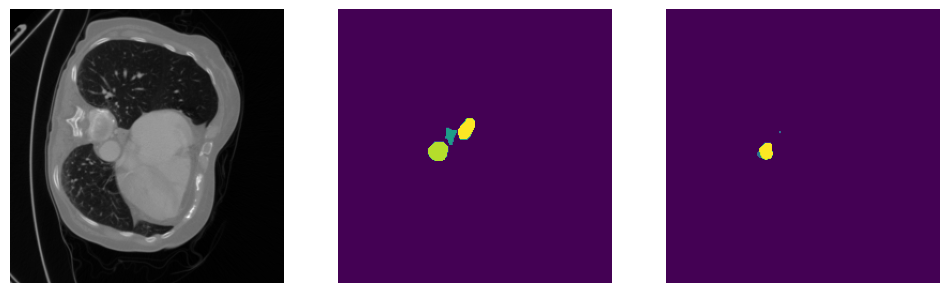

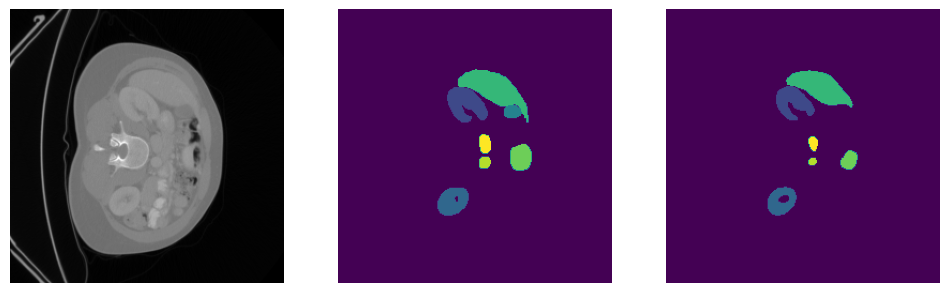

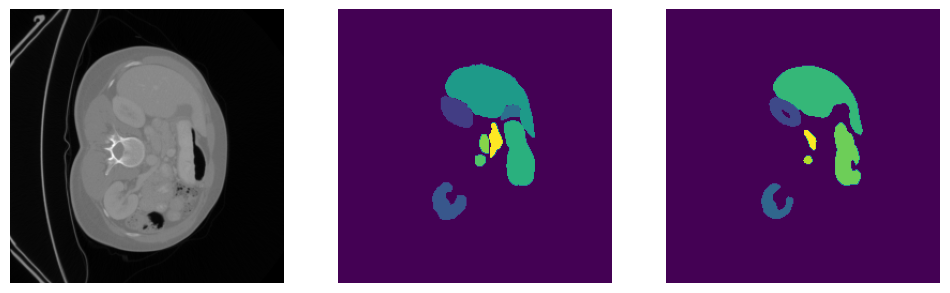

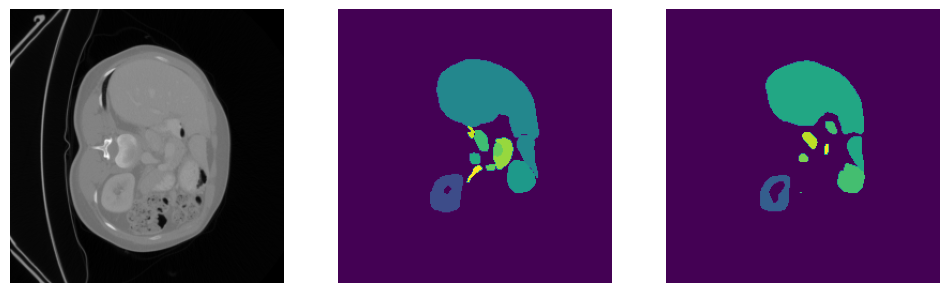

In [29]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# torch transforms involve non-random transformations (e.g., ToTensor)
torch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(DTYPE)
])

# we use albumentations library to apply random transforms the same to image and mask
alb_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE),
])

# create training dataset and loader
dataset = Synapse(torch_transform, alb_transform, train=False)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# load model from file (change filename here to load different model)
net = USCnet().to(device)
net.load_state_dict(torch.load(f"{NET_PATH}/uscnet_30.pth"))
net.eval()

# visualize the model's outputs
visualize(net, dataloader, device, 10)